In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
from torchsummary import summary

import numpy as np
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8):
        super().__init__()
        self.dim = dim
        self.dim_heads = dim // heads
        self.norm = nn.LayerNorm(dim)
        self.to_qkv = nn.Linear(dim, dim * 3)
        self.MHA = nn.MultiheadAttention(dim, heads, batch_first=True)       #dim means input sequence's dim

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim=-1)   #example: https://pytorch.org/docs/stable/generated/torch.chunk.html
        # q, k, v = [token for token in qkv]
        q,k,v = qkv
        result = self.MHA(q,k,v, need_weights=True)[0]
        return result


In [3]:
attn = Attention(dim=768, heads=8)
temp_tensor = torch.randn([16, 100, 768])
result = attn(temp_tensor)
print(result.shape)

torch.Size([16, 100, 768])


In [4]:
summary(attn.cuda(), (100, 768))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1             [-1, 100, 768]           1,536
            Linear-2            [-1, 100, 2304]       1,771,776
MultiheadAttention-3  [[-1, 100, 768], [-1, 100, 100]]               0
Total params: 1,773,312
Trainable params: 1,773,312
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.29
Forward/backward pass size (MB): 5857.03
Params size (MB): 6.76
Estimated Total Size (MB): 5864.09
----------------------------------------------------------------


In [5]:
class FeedForward(nn.Module):
    def __init__(self, dim, mlp_dim):
        super().__init__()
        layers = []
        layers.append(nn.LayerNorm(dim))
        layers.append(nn.Linear(dim, mlp_dim))
        layers.append(nn.GELU())
        layers.append(nn.Linear(mlp_dim, dim))
        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)

In [6]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):       #in paper head_dim = dim * 4
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([(Attention(dim, heads)),(FeedForward(dim, mlp_dim))]))         
        self.layers = nn.Sequential()

    def forward(self,x):
        for attn, ffn in self.layers:           #이전의 layers를 list에서 iterating하는 방식은 cuda, cpu device 오류남
            x = attn(x) + x
            x = ffn(x) + x
        return x
        

In [7]:
class VisionTransformer(nn.Module):

    def __init__(self, batch_size, num_classes, dim, depth, heads, mlp_dim, output_dim, img_dim = [3,224,224], patch_dim = [3,56,56], dim_head = 64):
        super().__init__()
        image_h = img_dim[1]
        image_w = img_dim[2]
        patch_h = patch_dim[1]
        patch_w = patch_dim[2]

        n_patches = (image_h // patch_h) * (image_w // patch_w)
        embedding_dim = img_dim[0] * patch_h * patch_w

        self.patch_dim = patch_dim
        self.img_dim = img_dim
        self.batch_size = batch_size
        self.n_patches = n_patches
        self.embedding_dim = embedding_dim

        #so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1).
        self.projection = nn.Sequential(     
            nn.LayerNorm(embedding_dim),                            #layernorm에 대한 언급은 못찾겠음
            nn.Linear(embedding_dim, dim),
            nn.LayerNorm(dim)
        )
        self.cls_token =nn.Parameter(torch.randn(1, dim))
        self.pos_embedding =nn.Parameter(torch.randn(1, n_patches+1, dim))

        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.norm = nn.LayerNorm(dim)
        self.classification_head = nn.Linear(dim, output_dim)


    def forward(self, img):
        channels=img.shape[1]

        x = img.unfold(2, self.patch_dim[1], self.patch_dim[2]).unfold(3, self.patch_dim[1], self.patch_dim[2])
        x = x.contiguous().view(self.batch_size, channels, self.n_patches, self.patch_dim[1], self.patch_dim[2])
        patches = x.permute(0, 2, 3, 4, 1)
        x = patches.contiguous().view(self.batch_size, self.n_patches, self.embedding_dim)
        x = self.projection(x)

        cls_tokens = self.cls_token.repeat(self.batch_size, 1, 1)

        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embedding[:, :(self.n_patches+1)]

        x = self.transformer(x)
        x = x[:,0]

        x = self.norm(x)                    #is this order right?
        x = self.classification_head(x)
        #많은 구현체에서 norm순서나 유무 vatiation이 많았다

        return x

In [26]:
model = VisionTransformer(batch_size=16, num_classes=10, dim=768, depth=12, heads=12, mlp_dim=3072, output_dim=1000)

In [27]:
x = torch.randn([16,3,224,224])    #(b,c,h,w)
y = model(x)

In [28]:
print(x.shape)
print(y.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16, 1000])


In [31]:
model = VisionTransformer(batch_size=2, num_classes=10, dim=768, depth=12, heads=12, mlp_dim=3072, output_dim=1000)      #batch_size=2로 지정해야만 돌아감!
summary(model.cuda(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1             [-1, 16, 9408]          18,816
            Linear-2              [-1, 16, 768]       7,226,112
         LayerNorm-3              [-1, 16, 768]           1,536
       Transformer-4              [-1, 17, 768]               0
         LayerNorm-5                  [-1, 768]           1,536
            Linear-6                 [-1, 1000]         769,000
Total params: 8,017,000
Trainable params: 8,017,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 1.45
Params size (MB): 30.58
Estimated Total Size (MB): 32.61
----------------------------------------------------------------


# Train test

## define dataset, dataloader

In [32]:
BATCH_SIZE = 32

In [39]:
std10_train = datasets.STL10(
    "../Datasets/STL10_PyTorch/",
    split = "train",
    transform=transforms.ToTensor(),
    download=True
)

Files already downloaded and verified


In [40]:
from sklearn.model_selection import train_test_split
import copy

In [41]:
train_indices, val_indices = train_test_split(range(len(std10_train)), test_size=0.1)
std10_val = copy.deepcopy(std10_train)
std10_train = Subset(std10_train, train_indices)
std10_val = Subset(std10_val, val_indices)

In [42]:
print(len(train_indices), len(val_indices))
print(len(std10_train), len(std10_val))

4500 500
4500 500


In [43]:
train_loader = DataLoader(
    std10_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    std10_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

## train

In [44]:
std10_train[0][0].shape

torch.Size([3, 96, 96])

In [57]:
model = VisionTransformer(batch_size=BATCH_SIZE, num_classes=10, dim=768, depth=12, heads=12, mlp_dim=3072, output_dim=10, img_dim=[3,96,96], patch_dim=[3,24,24]).to(device)

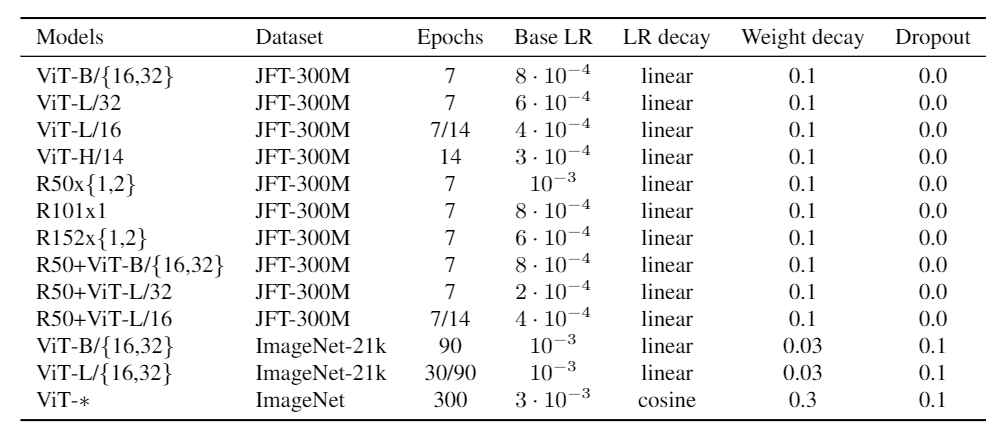

In [58]:
epochs=100
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [64]:
torch.argmax(torch.tensor([0.5,0.2]))

tensor(0)

In [87]:
all_losses = []
all_accs = []
for epoch in range(epochs):
    loss = 0
    loss_epoch = 0
    model.train()
    acc = 0.0
    correct = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        indices = torch.argmax(outputs, dim=1)
        correct += (y==indices).sum().item()

        loss_epoch += loss.item()
    loss_epoch /= len(train_loader)
    acc = correct / 4500
    print(loss_epoch)

    all_losses.append(loss_epoch)
    all_accs.append(acc)


In [86]:
all_losses

[2.3027387840407236]

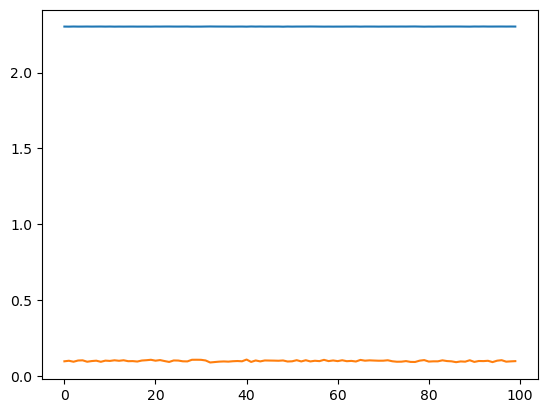

In [91]:
plt.plot(all_losses)
plt.plot(all_accs)